<a href="https://colab.research.google.com/github/DaniilAszn/Math_Leetcode_Problems/blob/main/1_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%80%D1%83%D0%BA%D0%BE%D0%BF%D0%B8%D1%81%D0%BD%D1%8B%D1%85_%D1%86%D0%B8%D1%84%D1%80_%D0%BF%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D1%8C%D1%8E_(Complete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 практика по NN by RTU MIREA**

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь (**дописал**).
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации (**поэкспериментировал**).
4.   Построить на одном графике loss для тестовой выборки и для обучающей (**даже accuracy есть**).
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации? (**у меня - нет, после 50 эпохи сильного роста не наблюдается**)
7.   Показать результат работы модели с использованием функции predict (необходимо написать функцию predict (**результат в конце (интрига)**)).


## Шаг 0: Установка PyTorch - фреймворка для работы с Deep learning

In [ ]:
!pip install torch

In [ ]:
# импортируем необходимые библиотеки
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('ggplot')
%matplotlib inline

#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы и на других ноутбуках
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [ ]:
# Разделение выборки на обучащую и тестовую
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

tensor(5)


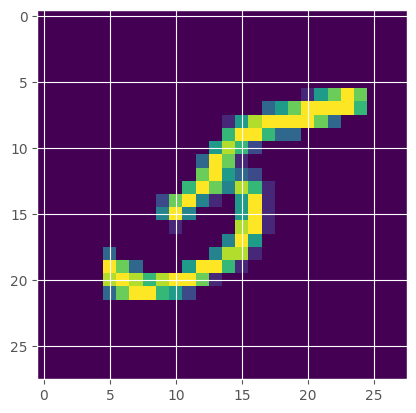

In [ ]:
#посмотрим на картинки
plt.imshow(X_train[35, :, :])
print(y_train[35])

In [ ]:
#у нас трёхмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])
print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## Шаг 1: Построение полносвязной нейронной сети

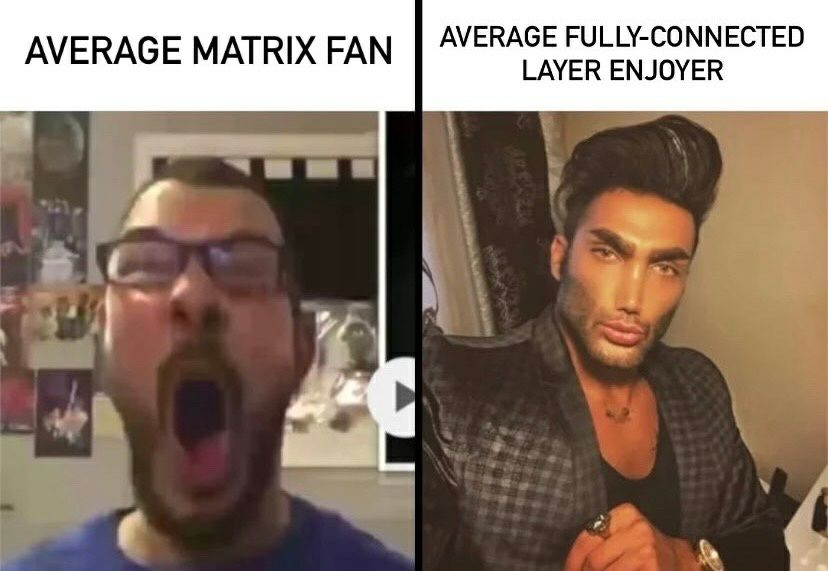

In [ ]:
count_col = 28 * 28 # количество признаков

# Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
    def __init__(self, n_neurons):
        super(MNISTnet, self).__init__()
        # входной слой не пишем, сразу скрытые делаем
        self.fc1 = th.nn.Linear(count_col, n_neurons)
        self.act1 = th.nn.Sigmoid()
        self.fc2 = th.nn.Linear(n_neurons, n_neurons)
        self.act2 = th.nn.Sigmoid()
        self.out = th.nn.Linear(n_neurons, 10) # второй аргумент 10, потому что
                                               # классифицируем цифры (0, .., 9)
        self.sm = th.nn.Softmax(dim=1) # выплёвывем вероятность

    def forward(self, x): # проход по построенной сети
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.out(x)
        # софтмакс не юзаем, так как это не обязательно - сеть обучится
        # и на выходах (интерпретация выходов в вероятности не нужна)
        return x # объект, пройденный через нашу нейронку

    def predict(self, data_input):
        with th.no_grad():
            x = self.forward(data_input)
            x = x.reshape(1, -1)
            x = self.sm(x)
            return x

mnist_net = MNISTnet(16)

In [ ]:
# ''' есть ли видеокарта?'''
# th.cuda.is_available()

In [ ]:
# '''смотрим, занята ли карта какими либо вычислениями'''
# !nvidia-smi

In [ ]:
# """ теперь нужно переложить вычисления на видеокарту"""

# device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
# MNIST_net = MNISTnet.to(device)

## Шаг 2.1: Обучение (40 эпох)

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

# #оптимизатор
optimizer = th.optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
batch_size = 1000 # размер батча (пакета)
epochs = 40 #число эпох

accuracy_list = []

train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test & train loss
    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(float(loss(test_preds, y_test)))

    train_preds = mnist_net.forward(X_train)
    train_loss_history.append(float(loss(train_preds, y_train)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    accuracy_list.append(float(accuracy))
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.6383000016212463
2: accuracy = 0.7232000231742859
3: accuracy = 0.7602999806404114
4: accuracy = 0.7807000279426575
5: accuracy = 0.7807999849319458
6: accuracy = 0.817300021648407
7: accuracy = 0.8094000220298767
8: accuracy = 0.8172000050544739
9: accuracy = 0.8356999754905701
10: accuracy = 0.8381999731063843
11: accuracy = 0.8468000292778015
12: accuracy = 0.8497999906539917
13: accuracy = 0.8586999773979187
14: accuracy = 0.8568999767303467
15: accuracy = 0.8659999966621399
16: accuracy = 0.8661999702453613
17: accuracy = 0.8715999722480774
18: accuracy = 0.8755000233650208
19: accuracy = 0.873199999332428
20: accuracy = 0.8726000189781189
21: accuracy = 0.8765000104904175
22: accuracy = 0.878000020980835
23: accuracy = 0.8809000253677368
24: accuracy = 0.8812999725341797
25: accuracy = 0.8813999891281128
26: accuracy = 0.8848000168800354
27: accuracy = 0.8862000107765198
28: accuracy = 0.8888000249862671
29: accuracy = 0.8914999961853027
30: accuracy = 0.892199993

## Шаг 3.1: Визуализация результатов (40 эпох)

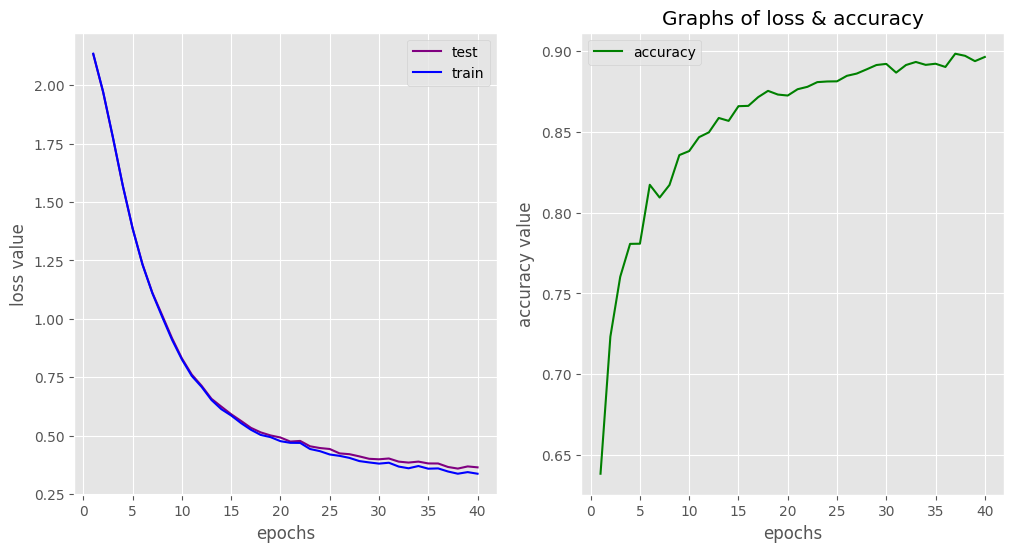

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.title('Graphs of loss & accuracy')

ax1.plot(list(range(1, epochs + 1)), test_loss_history, color='purple', label='test')
ax1.plot(list(range(1, epochs + 1)), train_loss_history, color = 'blue', label='train')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss value')
ax1.legend()

ax2.plot(list(range(1, epochs + 1)), accuracy_list, color = 'green', label='accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy value')
ax2.legend()

## Шаг 2.2: Обучение (200 эпох)

In [ ]:
# #функция потерь
loss = th.nn.CrossEntropyLoss()

# #оптимизатор
optimizer = th.optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

accuracy_list = []

train_loss_history = []
test_loss_history = []

# X_test = X_test.to(device)
# y_test = y_test.to(device)

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # отвечает за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]

        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    # test & train loss
    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(float(loss(test_preds, y_test)))

    train_preds = mnist_net.forward(X_train)
    train_loss_history.append(float(loss(train_preds, y_train)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    accuracy_list.append(float(accuracy))
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.13420000672340393
2: accuracy = 0.6844000220298767
3: accuracy = 0.6697999835014343
4: accuracy = 0.6819000244140625
5: accuracy = 0.7246999740600586
6: accuracy = 0.7630000114440918
7: accuracy = 0.7998999953269958
8: accuracy = 0.8065999746322632
9: accuracy = 0.8195000290870667
10: accuracy = 0.8317999839782715
11: accuracy = 0.8418999910354614
12: accuracy = 0.8439000248908997
13: accuracy = 0.8561999797821045
14: accuracy = 0.8568999767303467
15: accuracy = 0.8597000241279602
16: accuracy = 0.8665000200271606
17: accuracy = 0.8651999831199646
18: accuracy = 0.8641999959945679
19: accuracy = 0.8669999837875366
20: accuracy = 0.8730999827384949
21: accuracy = 0.8738999962806702
22: accuracy = 0.8723999857902527
23: accuracy = 0.8736000061035156
24: accuracy = 0.8794000148773193
25: accuracy = 0.8845000267028809
26: accuracy = 0.8809000253677368
27: accuracy = 0.8787000179290771
28: accuracy = 0.8853999972343445
29: accuracy = 0.8795999884605408
30: accuracy = 0.88120

## Шаг 3.2: Визуализация результатов (200 эпох)

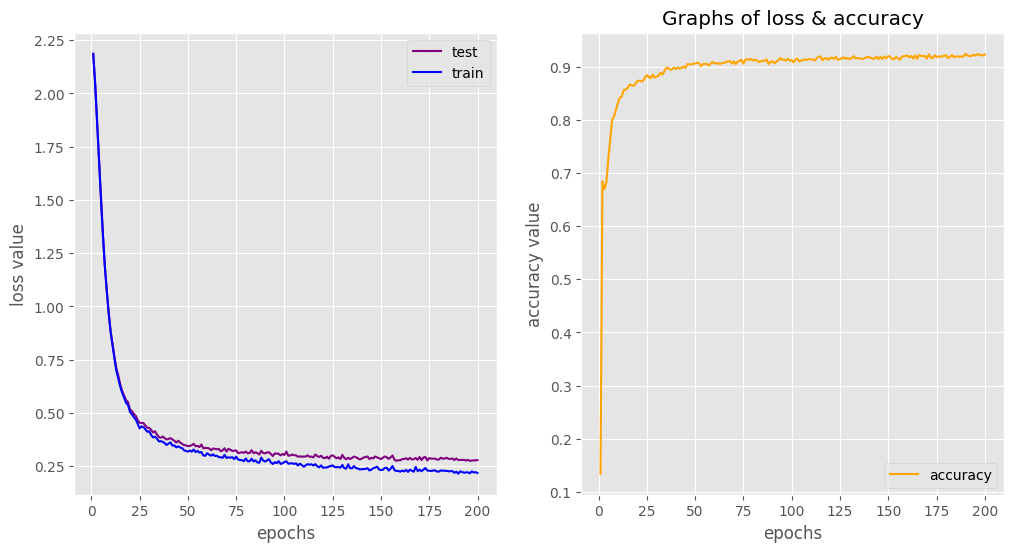

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.title('Graphs of loss & accuracy')

ax1.plot(list(range(1, epochs + 1)), test_loss_history, color='purple', label='test')
ax1.plot(list(range(1, epochs + 1)), train_loss_history, color = 'blue', label='train')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss value')
ax1.legend()

ax2.plot(list(range(1, epochs + 1)), accuracy_list, color = 'orange', label='accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy value')
ax2.legend()

## Шаг 4: Прогноз модели

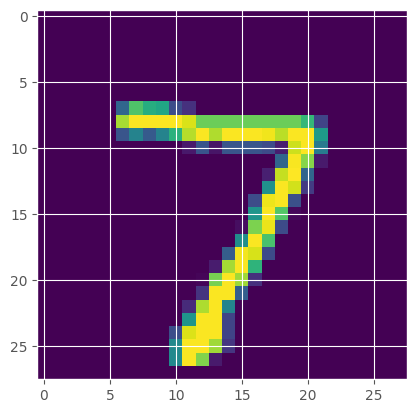

Я считаю, что нарисована цифра 7, а нейросеть думает, что: 7


In [ ]:
sample_input = X_test[0]
prediction = mnist_net.predict(sample_input)
plt.imshow(X_test[0].reshape(28,28))
plt.show()
print(f'Я считаю, что нарисована цифра 7, а нейросеть думает, что: {th.argmax(prediction).item()}')

Ну вот теперь точно ИИ захватит мир...